In [1]:
import camb
import pywigxjpf as pywig
from joblib import Parallel, delayed
import sys, argparse, multiprocessing
#from common import *
from scipy.signal import savgol_filter

In [2]:
import numpy as np
import healpy as hp
import matplotlib
import matplotlib.pyplot as plt
import os

In [3]:
nside = 2560

In [4]:
print("  Creating pywig tables...")
NSIDE_MAX = 4096
pywig.wig_table_init(3*nside, 3)
pywig.wig_temp_init(3*nside)

  Creating pywig tables...


In [103]:
L_RECONST_MAX = 200

In [6]:
def GammakSZ(l1, l2, l, Cltd) :
    pref = np.sqrt((2.0*l1+1)*(2.0*l2+1)*(2.0*l+1)/4.0/np.pi)
    wig = pywig.wig3jj(2*l1, 2*l2, 2*l, 0, 0, 0) # 2*[j1,j2,j3,m1,m2,m3]
    return pref*wig*Cltd[l2]

def getNinv(l, ls, Cltd, ClTT, Cldd) :
    Ninv = 0.0
    if l < L_RECONST_MAX+1 :
        print("Working on l =", l)
        for l1 in ls: # TODO: don't include monopole, dipole contributions?
            for l2 in ls:
                Ninv += GammakSZ(l1, l2, l, Cltd)**2 / ClTT[l1] / Cldd[l2]
        Ninv /= (2.0*l + 1.0)
    else :
        Ninv = 1.0e50 # N = 1.0e-50
    return Ninv

In [7]:
h=0.69
pars = camb.CAMBparams()
pars.set_cosmology(H0=100.0*h, ombh2=0.048*h**2, omch2=0.262*h**2, mnu=0.06, omk=0)
pars.InitPower.set_params(As=2e-9, ns=0.96, r=0)
pars.set_for_lmax(6144, lens_potential_accuracy=0)
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='K')
l=np.arange(0,len(powers['total'][:,0]))
cambFactor = l*(l+1)/(2*np.pi)
CMB_camb = powers['total'][:,0]/cambFactor
CMB_camb[0]=0.0

<ipython-input-7-d860381747c2>:10: RuntimeWarning: invalid value encountered in true_divide
  CMB_camb = powers['total'][:,0]/cambFactor


In [8]:
kSZ = np.load('./kSZ_NS_2560_R_2968_P_2048_DV_256_Sd_945986.npy')
overdensity = np.load('./overdensity_NS_2560_R_2968_P_2048_DV_256_Sd_945986.npy')
VelocityField = np.load('./VelocityField_NS_2560_R_2968_P_2048_DV_256_Sd_945986.npy')

In [9]:
rho_map = overdensity

ksz_PS = hp.anafast(kSZ)

CMB_map = hp.sphtfunc.synfast(CMB_camb,nside=nside);
    
Obs_T_map = kSZ + CMB_map

ClTT = hp.anafast(Obs_T_map)
ClTT_filtered = np.concatenate(([1.0], savgol_filter(ClTT[1:], 51, 3)))
Cldd = hp.anafast(rho_map)
Cltd = hp.anafast(rho_map, map2=-rho_map)
ls = np.arange(ClTT.size)
    
dTlm = hp.map2alm(Obs_T_map)
dlm = hp.map2alm(rho_map)

dTlm_resc = hp.almxfl(dTlm, 1.0/ClTT)
dT_resc = hp.alm2map(dTlm_resc, nside)
dlm = -1.0*dlm # dlm_resc = hp.almxfl(dlm, 1.0) #Cltd/Cldd
d_resc = hp.alm2map(dlm, nside)

/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:433: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


In [104]:
#figuring out scaling factor
print("Scaling factor")
#Compute noise (expensive, need to optimize?)
print("Computing noise.")
ncores = multiprocessing.cpu_count()
lsMax=np.arange(5700)
#Ninv = [ getNinv(l, lsMax, Cltd, ClTT, Cldd) for l in range(L_RECONST_MAX) ]
#Ninv = Parallel(n_jobs=ncores)(delayed(getNinv)(l, ls, Cltd, ClTT, Cldd) for l in ls)
#N = 1.0/np.array(Ninv)
N = np.zeros_like(ls, dtype=np.int)
#N[:100] = 1.0
    
unnorm_veff_reconstlm = hp.map2alm(dT_resc*d_resc,lmax=L_RECONST_MAX)
veff_reconstlm = hp.almxfl(unnorm_veff_reconstlm,fl=N)
unnorm_veff_reconst_ps = hp.alm2cl(unnorm_veff_reconstlm)
unnorm_veff_reconst = hp.alm2map(unnorm_veff_reconstlm, nside)
veff_reconst = hp.alm2map(veff_reconstlm, nside)


Scaling factor
Computing noise.


<ipython-input-104-ff57cab92504>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  N = np.zeros_like(ls, dtype=np.int)


In [11]:
N

array([0, 0, 0, ..., 0, 0, 0])

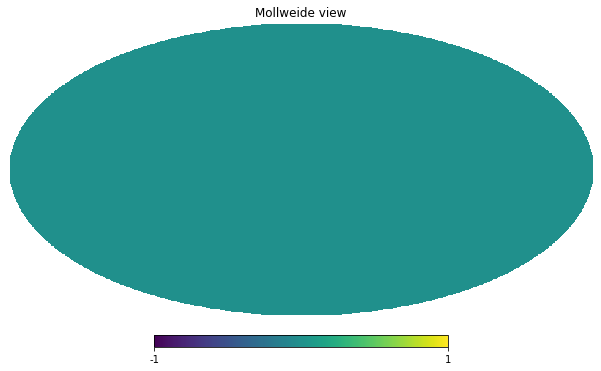

In [12]:
hp.mollview(veff_reconst)

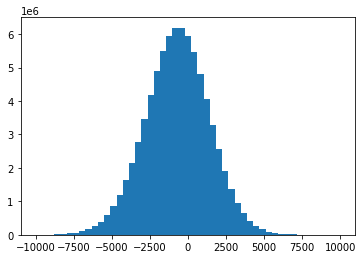

In [17]:
plt.hist(VelocityField,bins=np.linspace(-10000,10000));

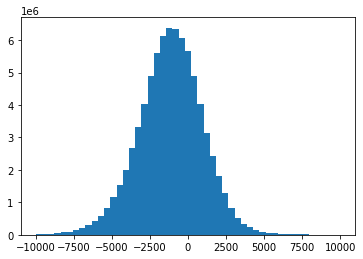

In [21]:
plt.hist(10**9*veff_reconst,bins=np.linspace(-10000,10000));

In [27]:
diff = VelocityField-(10**9*veff_reconst+400)

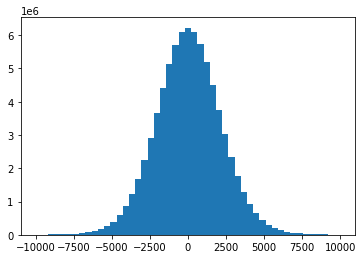

In [28]:
plt.hist(diff,bins=np.linspace(-10000,10000));

In [42]:
import numpy as np
import sklearn.mixture

mixture = sklearn.mixture.GaussianMixture()

# result
r = mixture.fit(VelocityField[:, np.newaxis]) # GMM requires 2D data as of sklearn version 0.16
print("mean : %f, std dev : %f" % (r.means_[0, 0], np.sqrt(r.covariances_[0, 0])))

mean : -719.786416, std dev : 2100.559290


In [25]:
mixture = sklearn.mixture.GaussianMixture()

# result
r = mixture.fit(10**9*veff_reconst[:, np.newaxis]) # GMM requires 2D data as of sklearn version 0.16
print("mean : %f, std dev : %f" % (r.means_[0, 0], np.sqrt(r.covariances_[0, 0])))

mean : -1157.810348, std dev : 2142.184955


In [29]:
mixture = sklearn.mixture.GaussianMixture()

# result
r = mixture.fit(diff[:, np.newaxis]) # GMM requires 2D data as of sklearn version 0.16
print("mean : %f, std dev : %f" % (r.means_[0, 0], np.sqrt(r.covariances_[0, 0])))

mean : 38.023932, std dev : 2181.742155


In [47]:
velField_alm = hp.map2alm(VelocityField,lmax=L_RECONST_MAX)

In [48]:
velField_LowL = hp.alm2map(velField_alm,nside)

/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


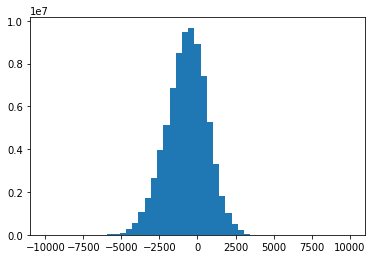

In [39]:
plt.hist(velField_LowL,bins=np.linspace(-10000,10000));

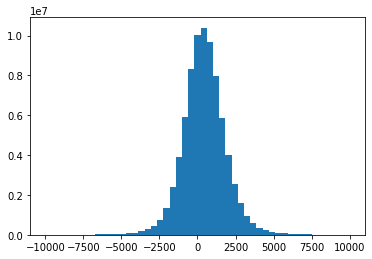

In [43]:
plt.hist(velField_LowL-10**9*veff_reconst,bins=np.linspace(-10000,10000));

In [44]:
mixture = sklearn.mixture.GaussianMixture()

# result
r = mixture.fit((velField_LowL-10**9*veff_reconst)[:, np.newaxis]) # GMM requires 2D data as of sklearn version 0.16
print("mean : %f, std dev : %f" % (r.means_[0, 0], np.sqrt(r.covariances_[0, 0])))

mean : 438.023932, std dev : 1464.922968


## Cl resclaing

In [21]:
def Correlation(map1, map2):
    return hp.anafast(map1,map2)/(np.sqrt(hp.anafast(map1)*hp.anafast(map2))+np.finfo(np.float32).eps)

In [195]:
L_RECONST_MAX=ClTT.size

In [196]:
velField_alm = hp.map2alm(VelocityField,lmax=L_RECONST_MAX)
velField_LowL = hp.alm2map(velField_alm,nside)

unnorm_veff_reconstlm = hp.map2alm(dT_resc*d_resc,lmax=L_RECONST_MAX)
unnorm_veff_reconst_ps = hp.alm2cl(unnorm_veff_reconstlm)
unnorm_veff_reconst = hp.alm2map(unnorm_veff_reconstlm, nside)

/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


In [197]:
velField_ps = hp.anafast(VelocityField)
velRecon_ps = hp.anafast(unnorm_veff_reconst)

In [198]:
unnorm_veff_reconstlm = hp.map2alm(dT_resc*d_resc,lmax=L_RECONST_MAX)

In [199]:
knownOverReconFac = np.sqrt(velField_ps/velRecon_ps)[:L_RECONST_MAX]

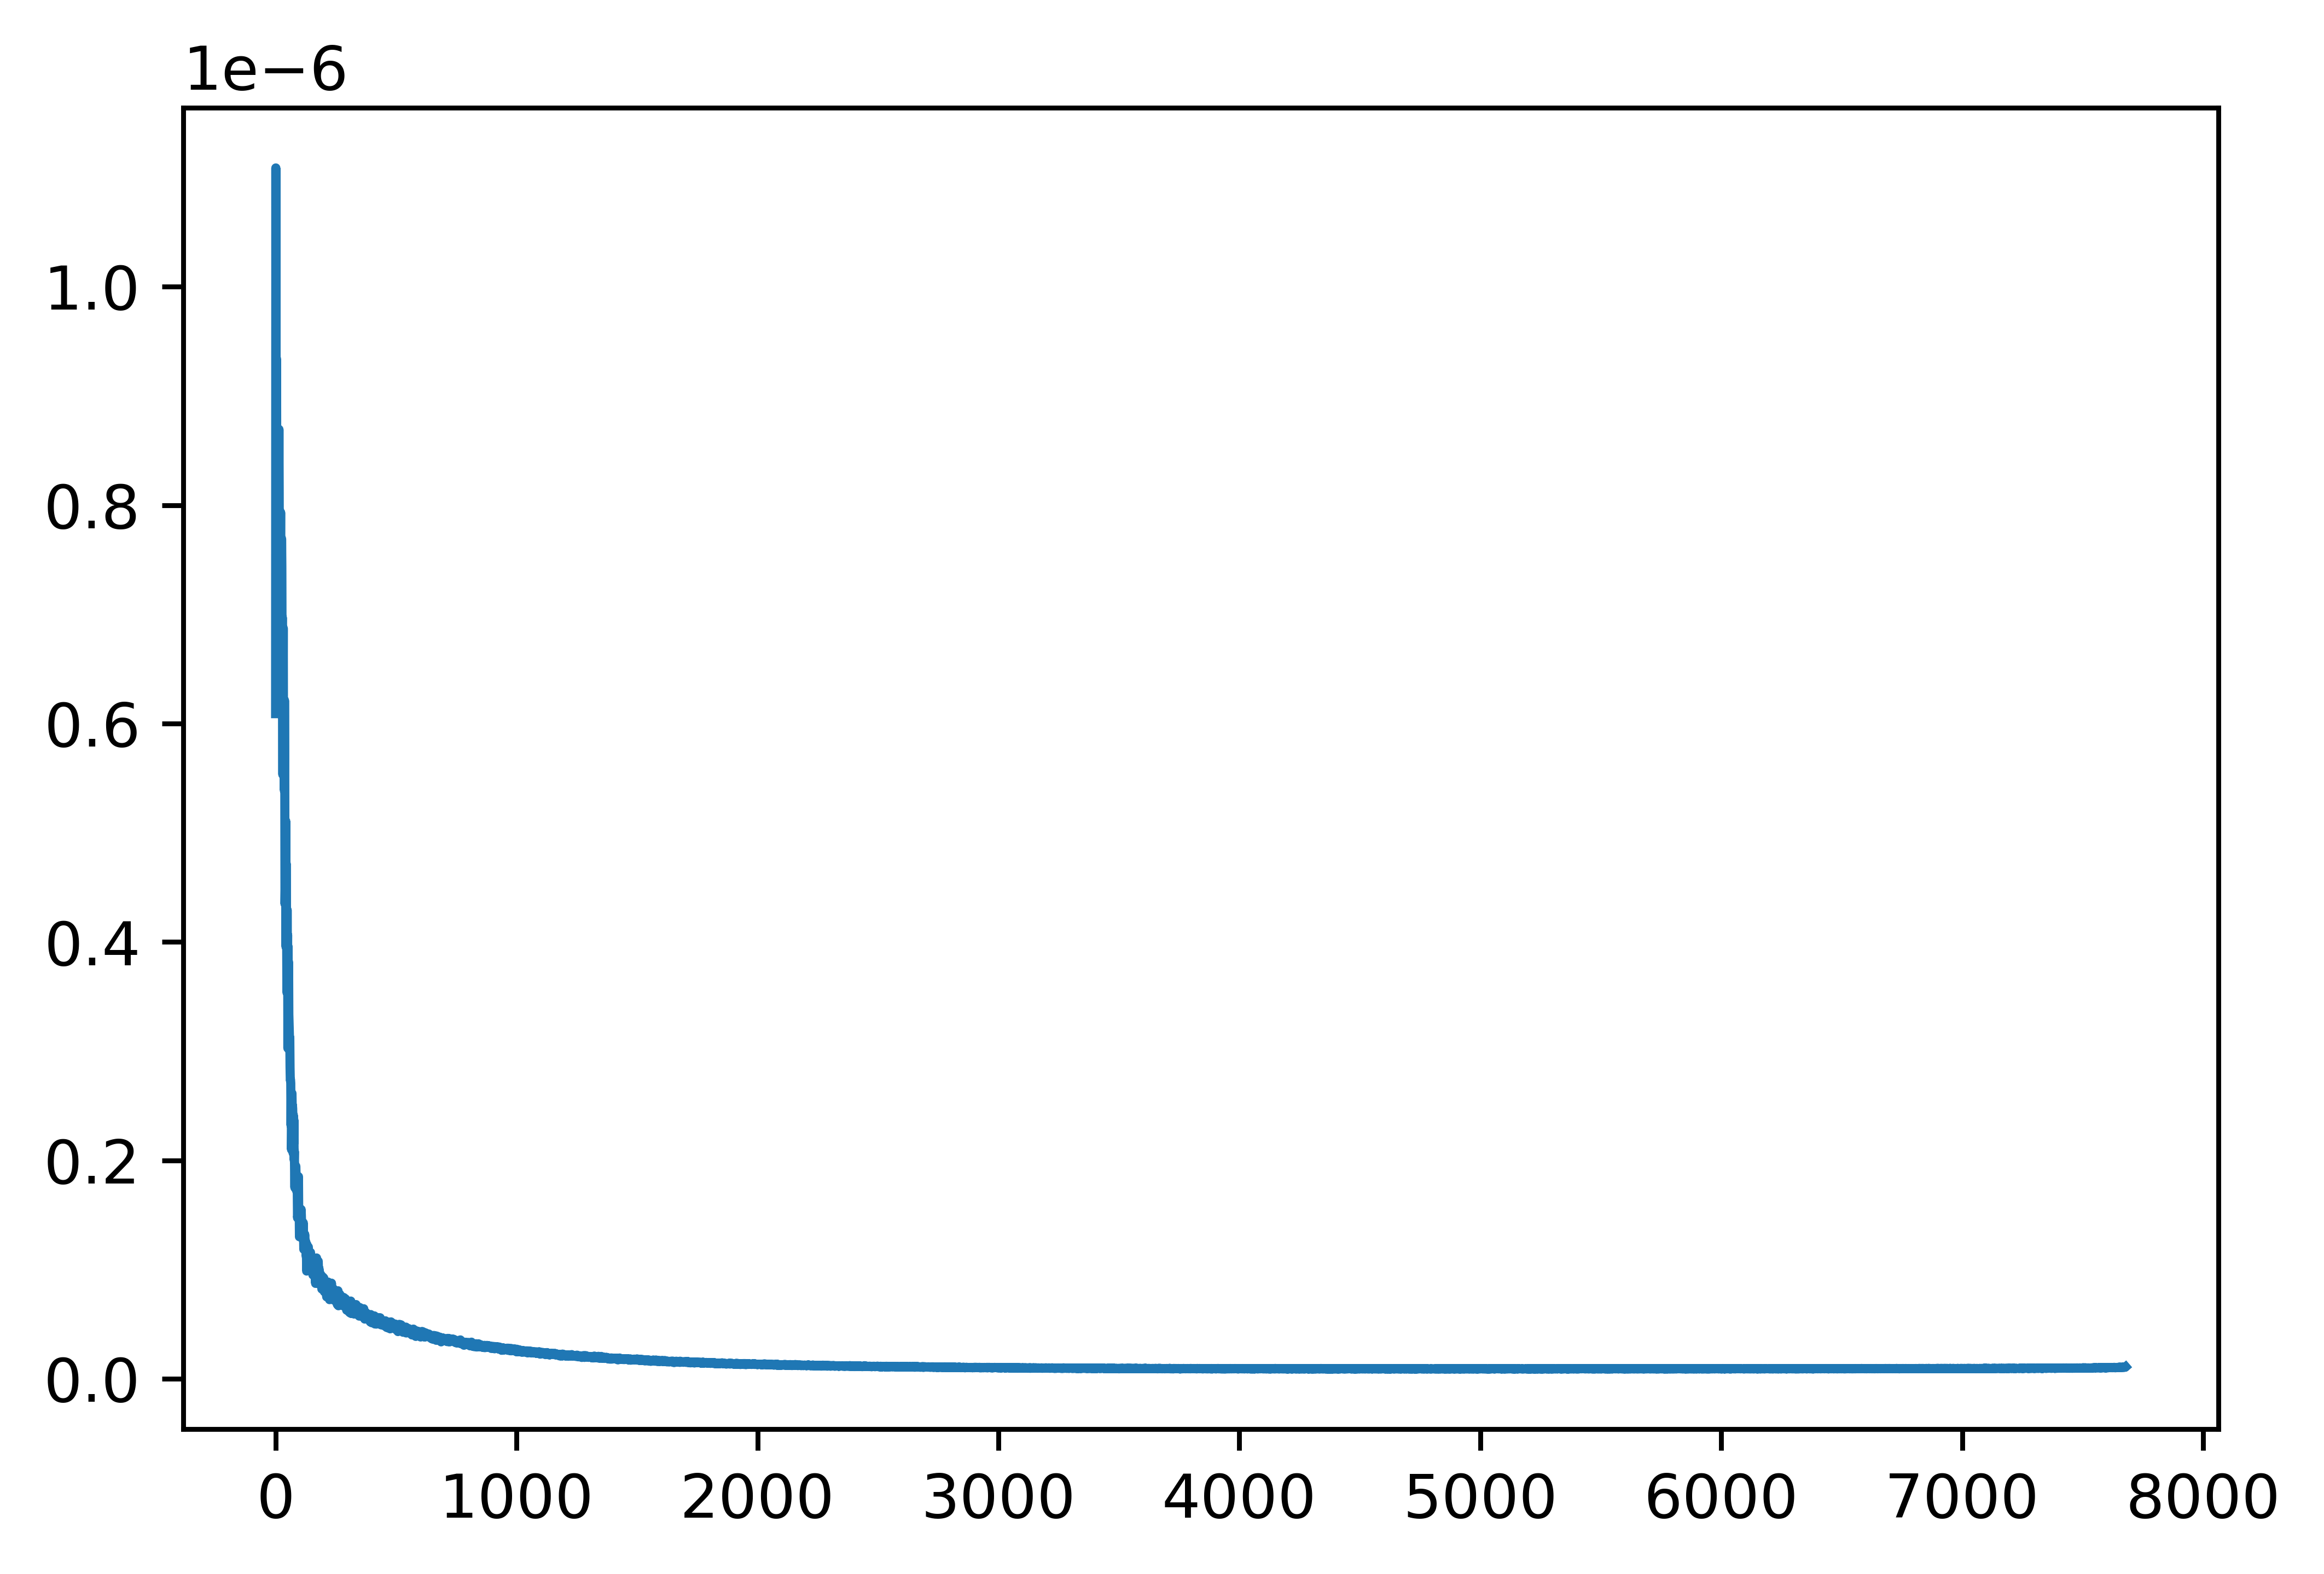

In [200]:
plt.figure(dpi=800)
plt.plot(knownOverReconFac);

In [201]:
veff_reconstlm_ClRescale = hp.almxfl(unnorm_veff_reconstlm,fl=knownOverReconFac)

In [202]:
veff_recon_ClRescale = hp.alm2map(veff_reconstlm_ClRescale,nside)

/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


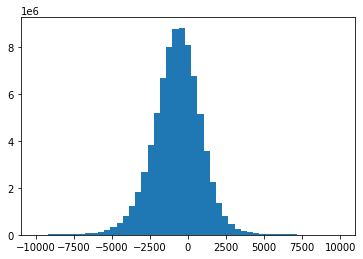

In [203]:
plt.hist(veff_recon_ClRescale,bins=np.linspace(-10000,10000));

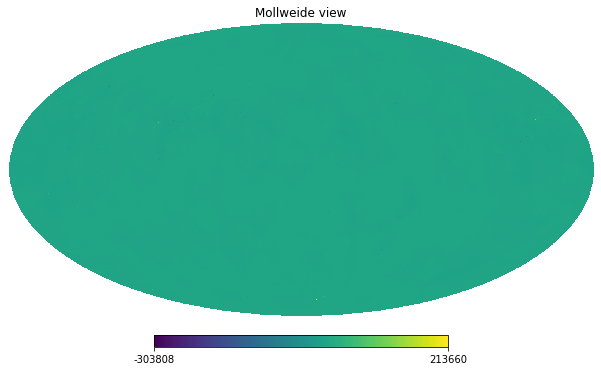

In [204]:
hp.mollview(veff_recon_ClRescale,xsize=1600)

In [205]:
clRescaleCorr = Correlation(veff_recon_ClRescale,VelocityField)

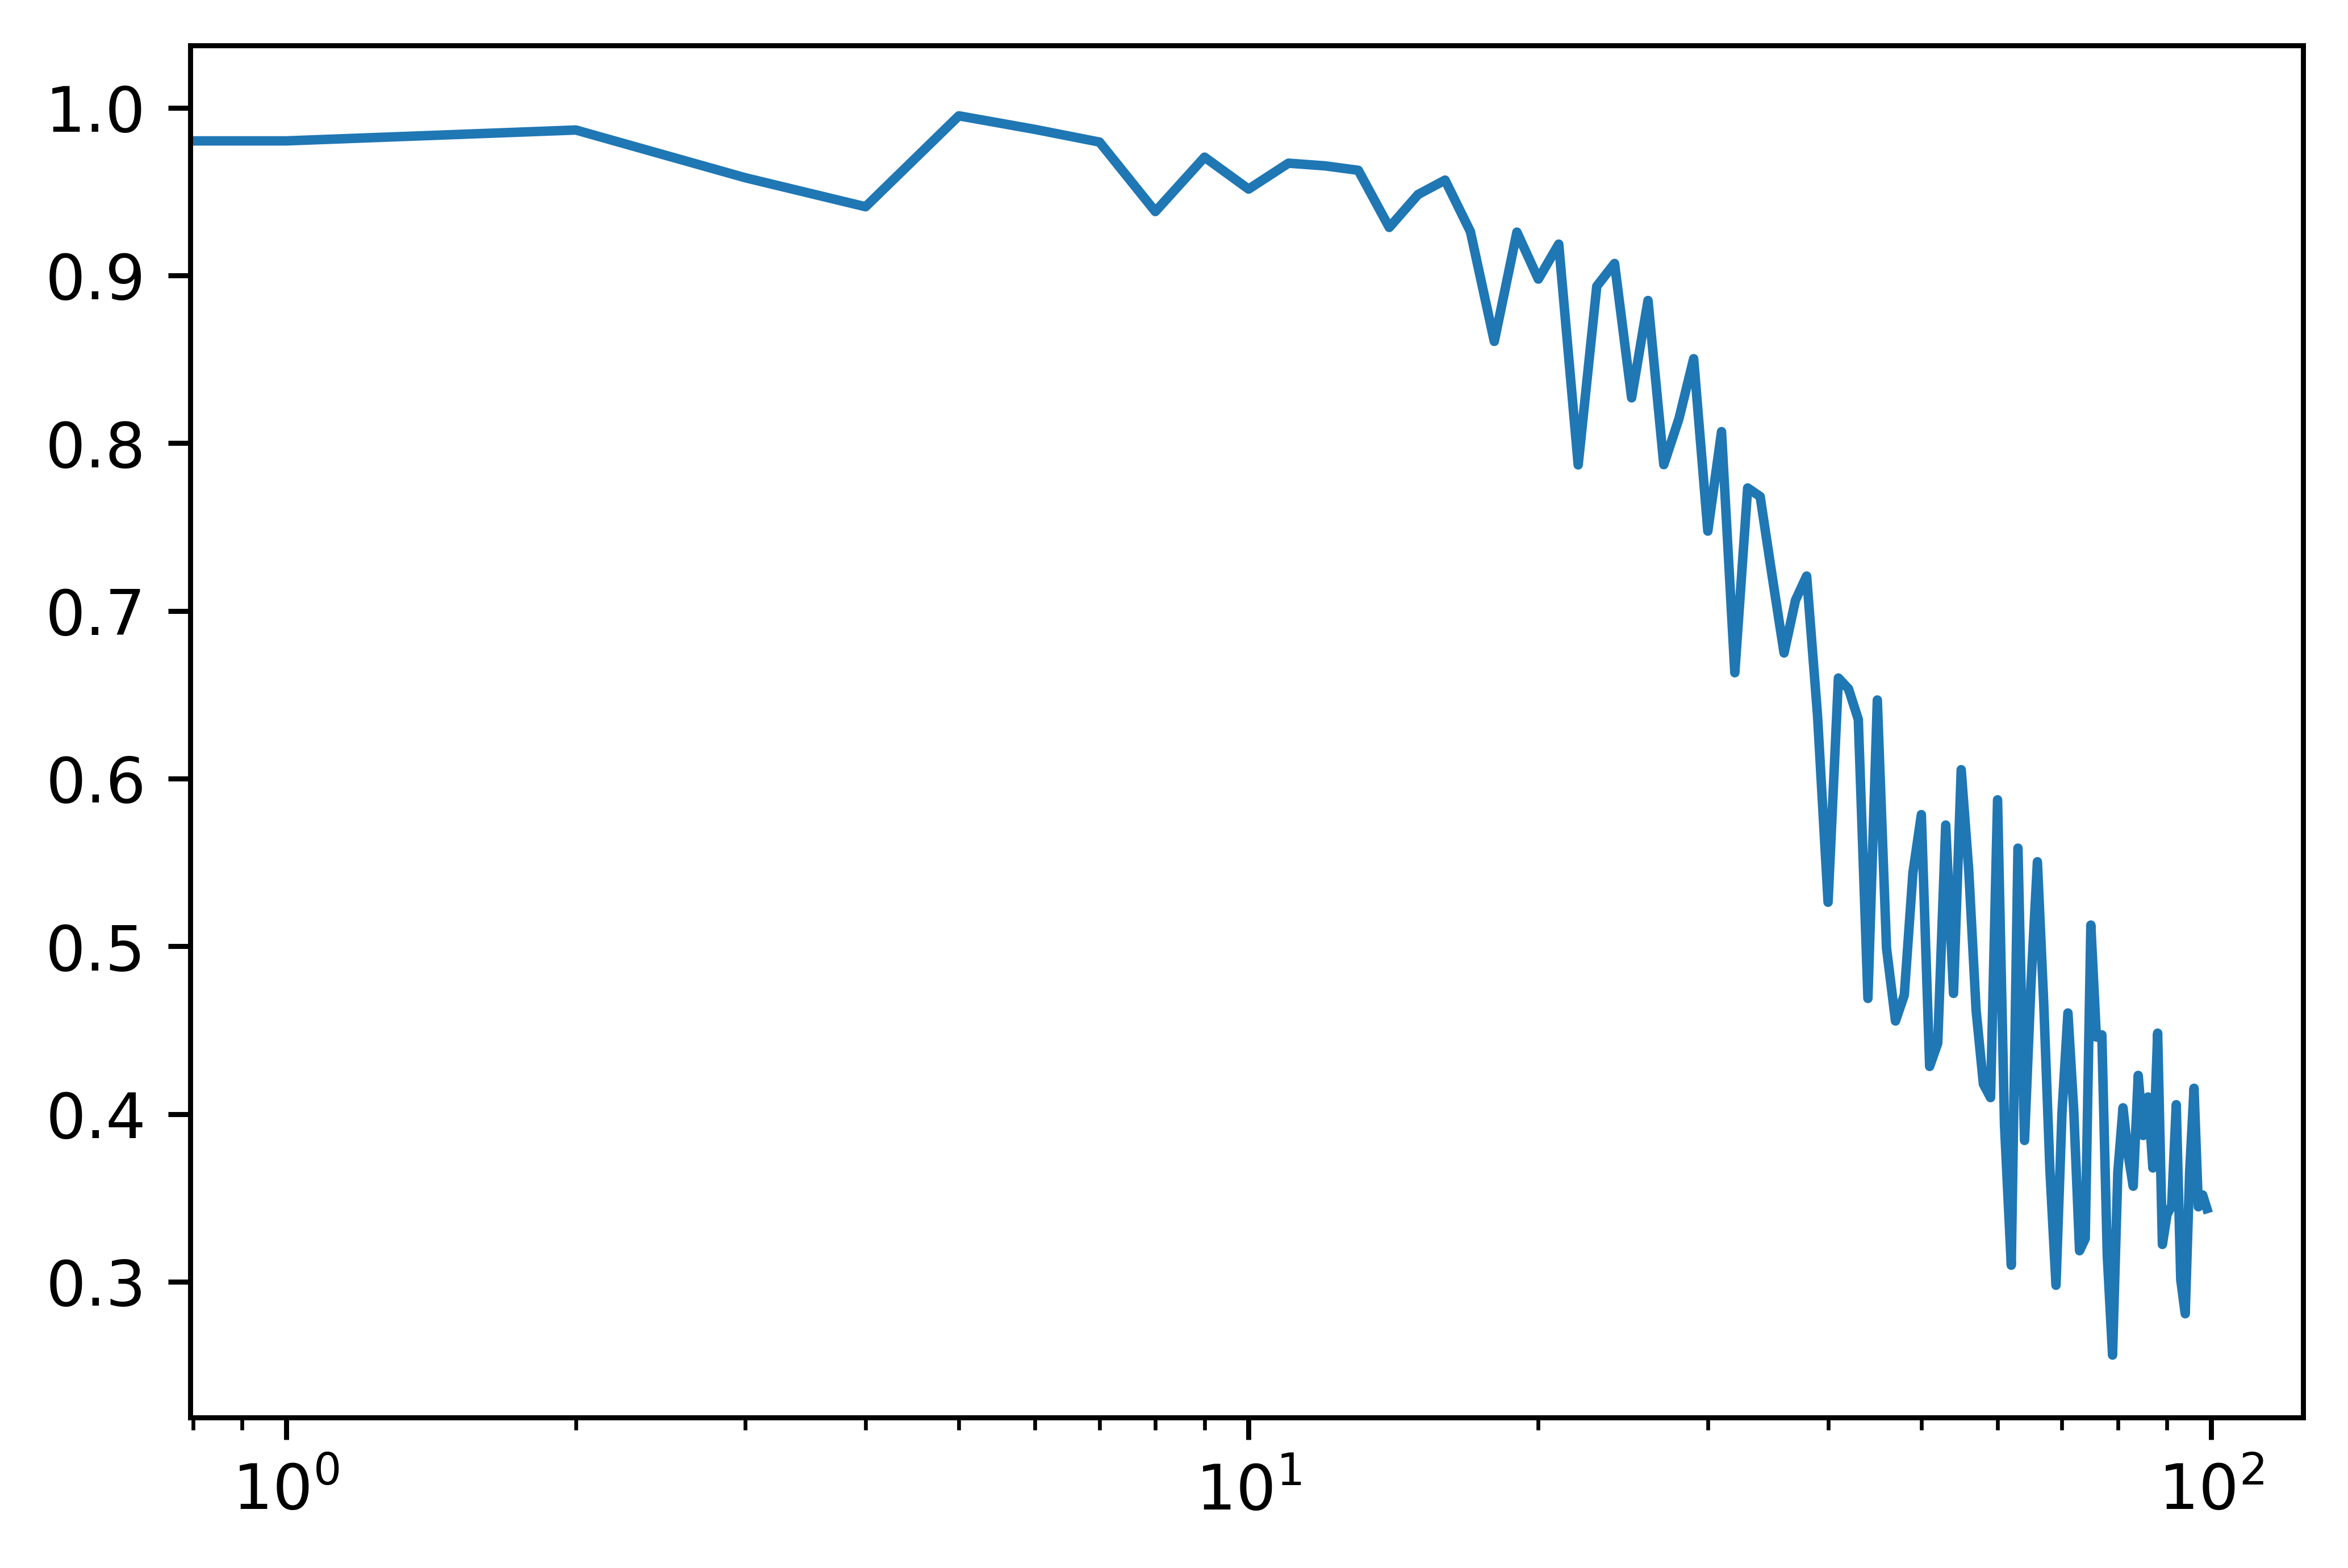

In [206]:
plt.figure(dpi=800)
plt.semilogx(clRescaleCorr[:100])

In [207]:
noRescaleCorr = Correlation(unnorm_veff_reconst,VelocityField)

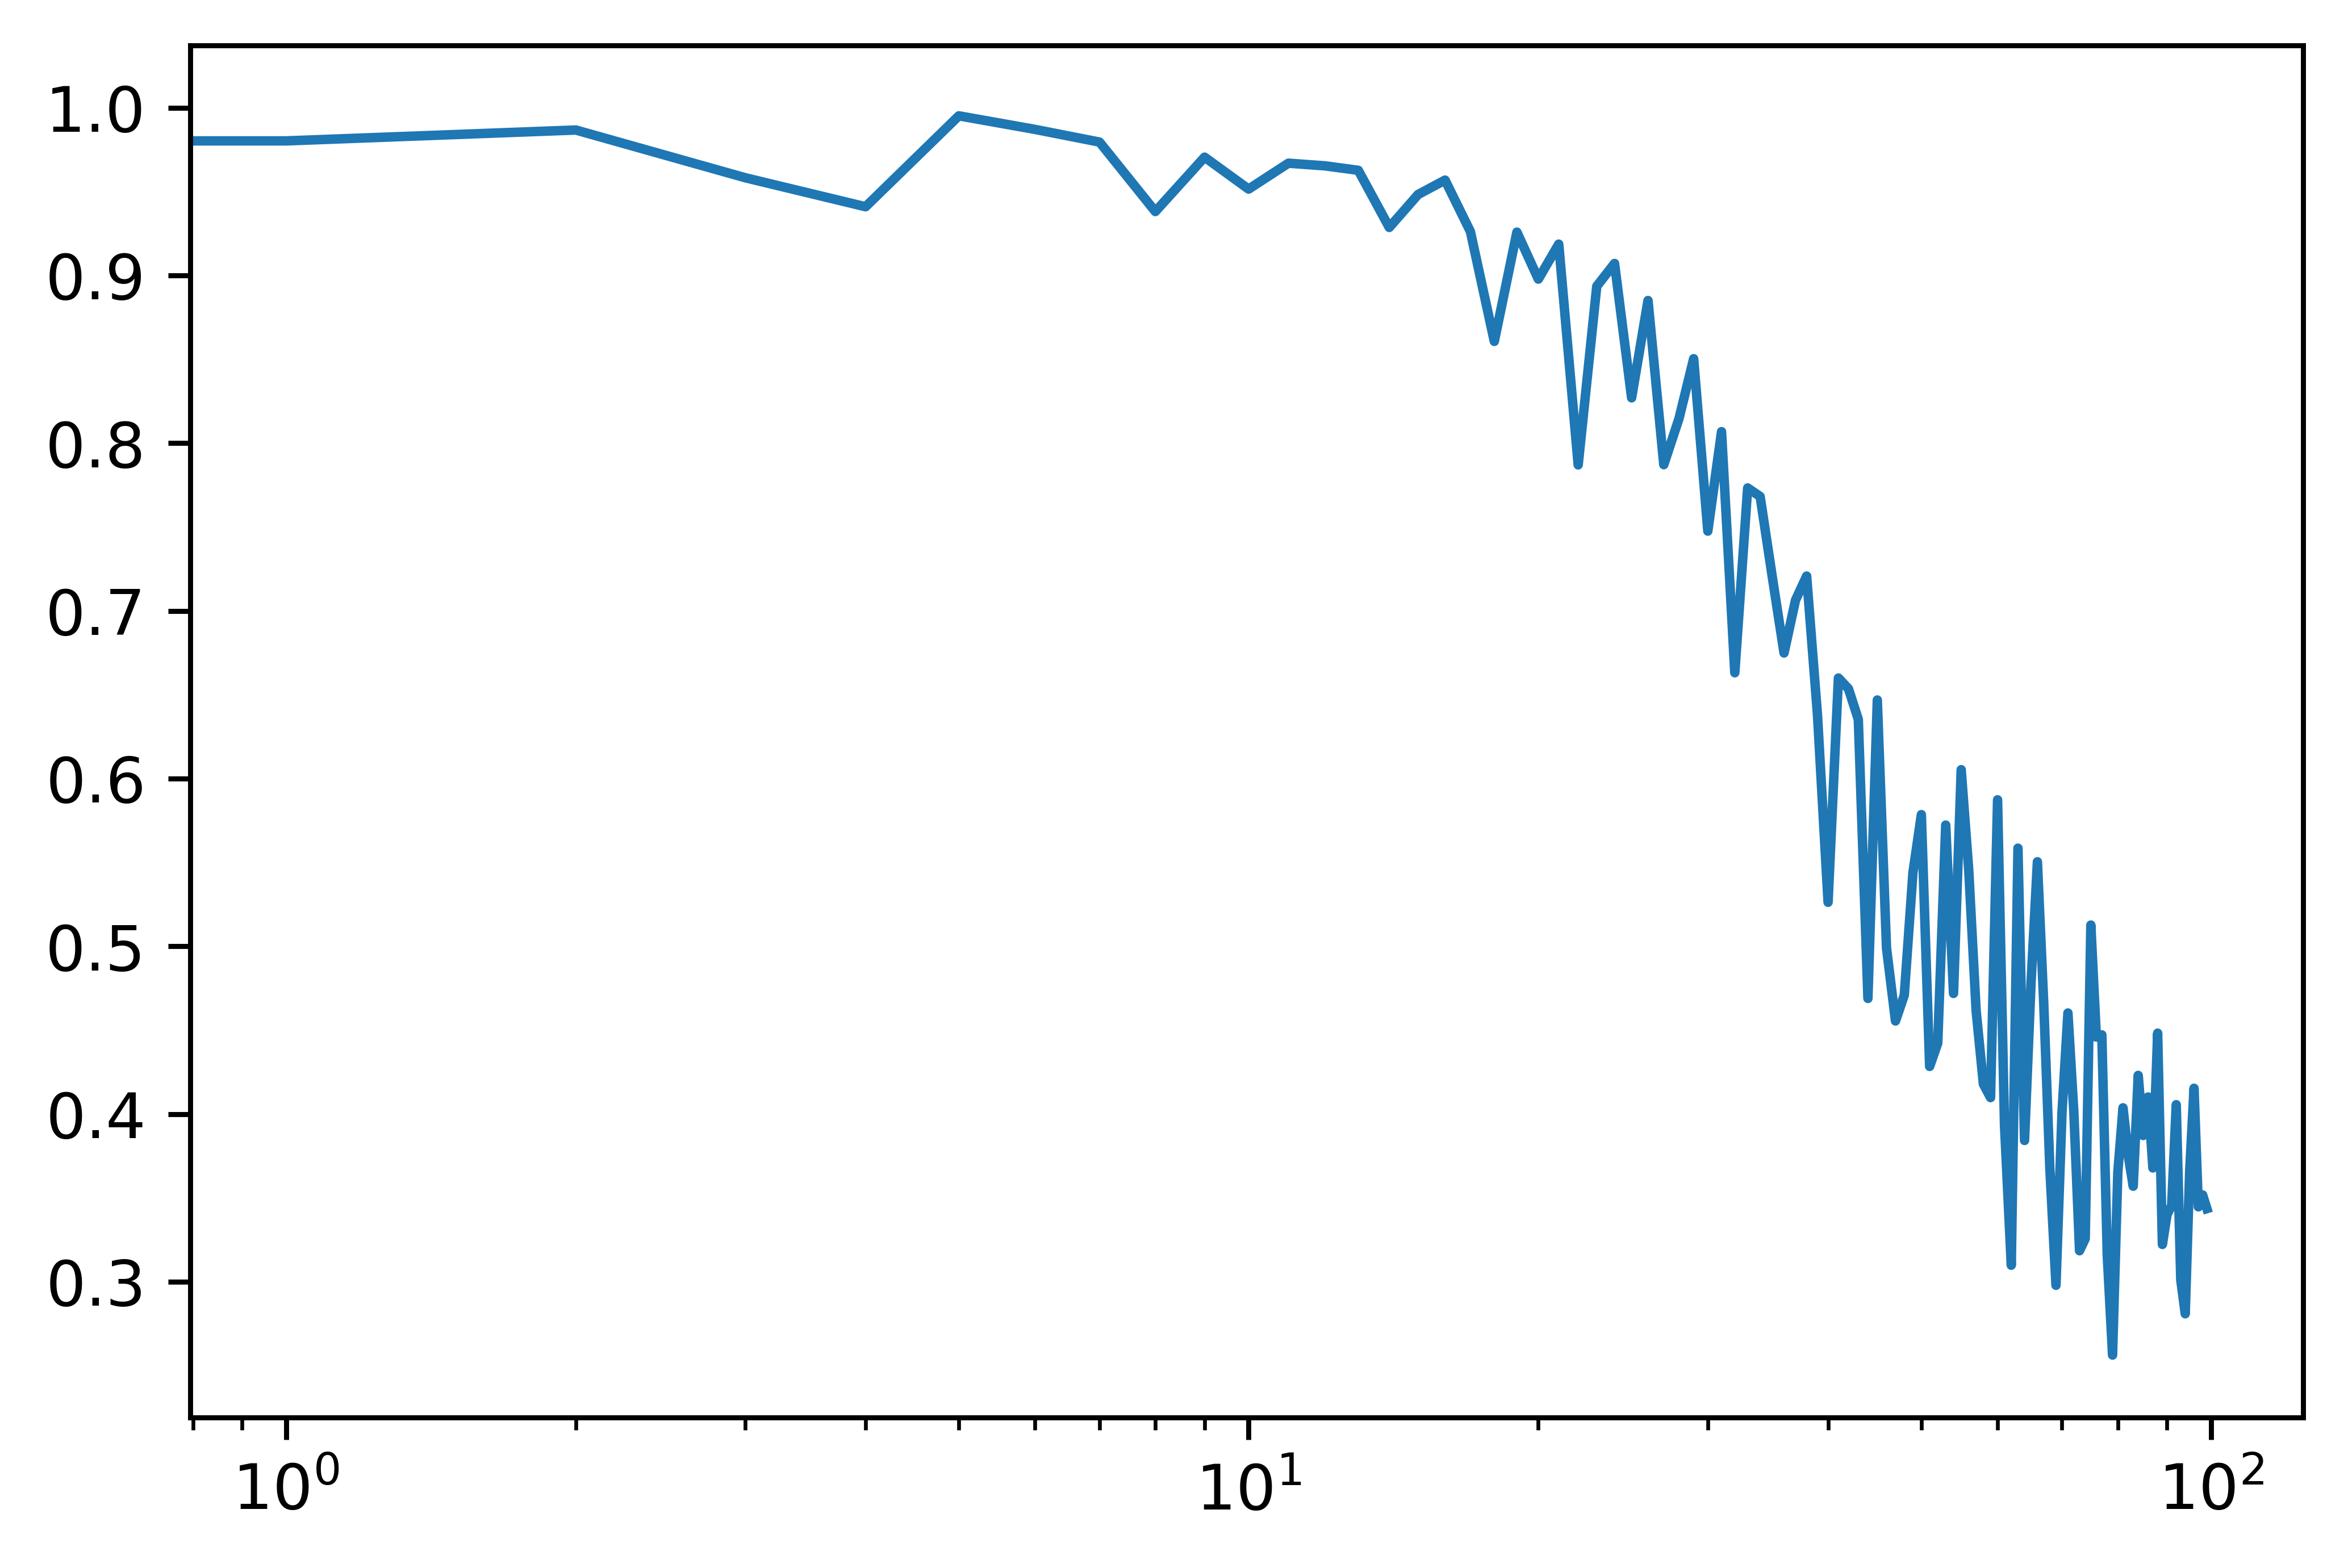

In [208]:
plt.figure(dpi=800)
plt.semilogx(noRescaleCorr[:100])

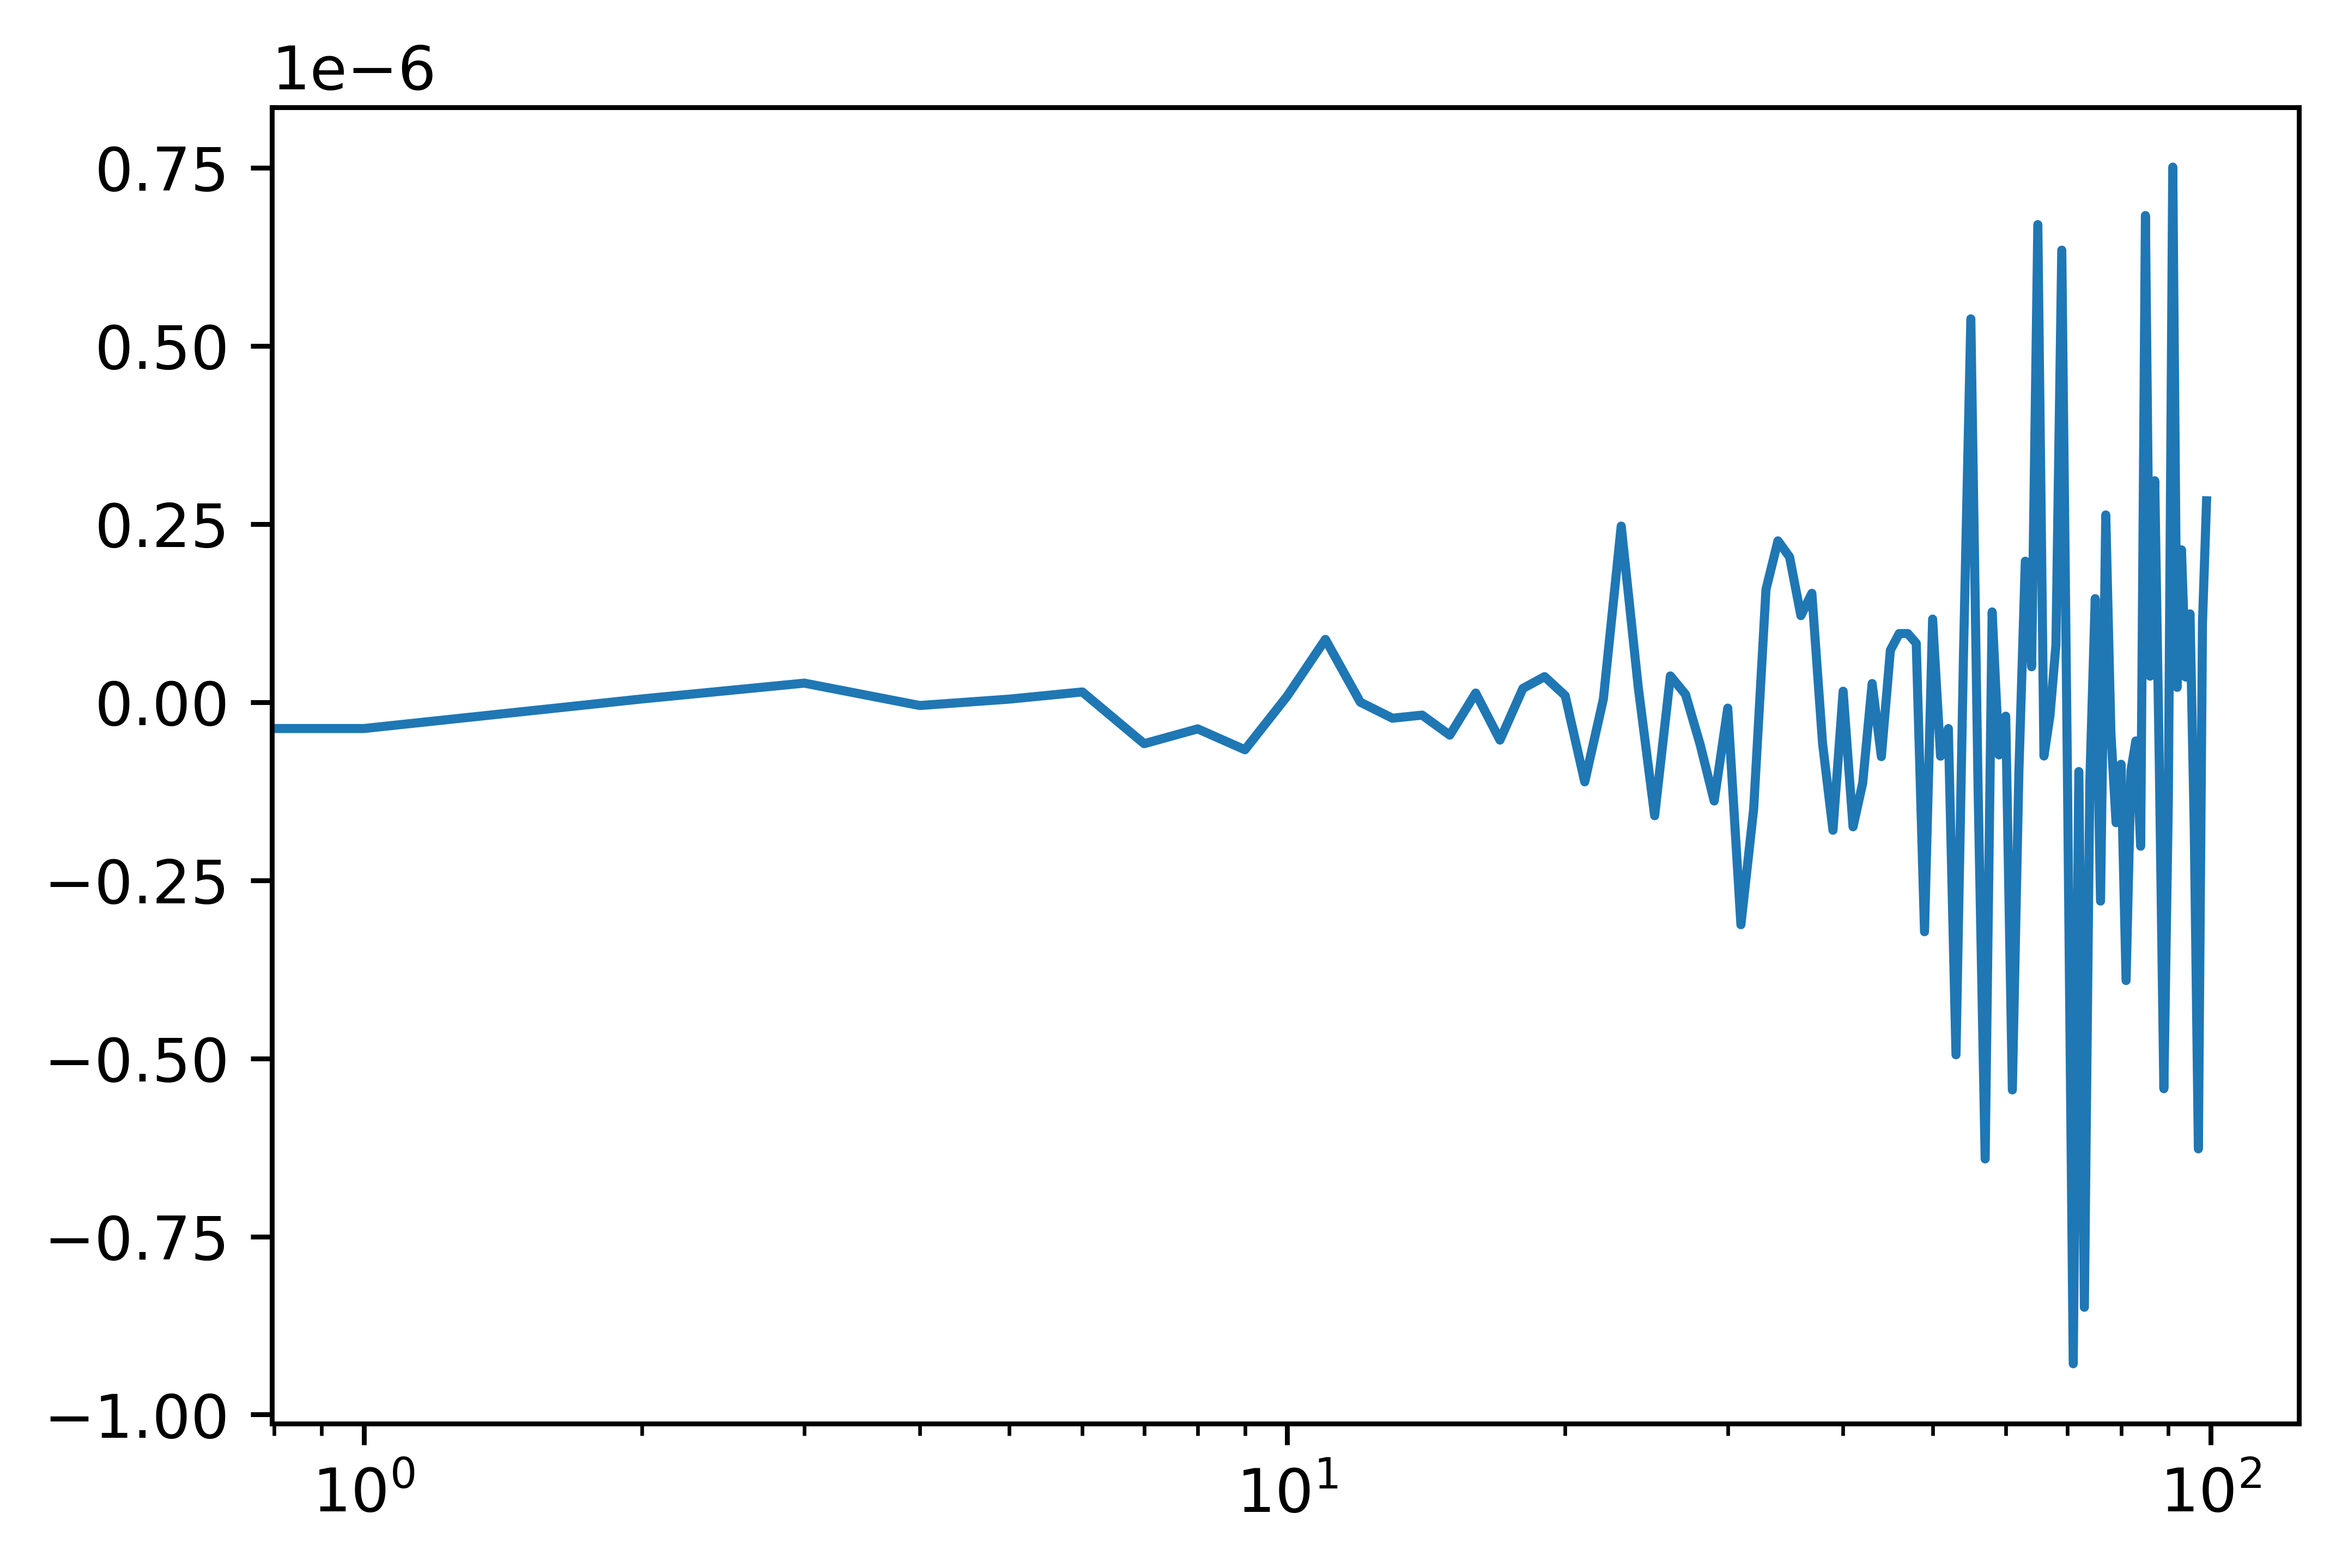

In [209]:
plt.figure(dpi=800)
plt.semilogx(clRescaleCorr[:100]-noRescaleCorr[:100])

The rescaling does not effect the correlation between the maps - good news

In [210]:
removePeculiar = velField_LowL-veff_recon_ClRescale

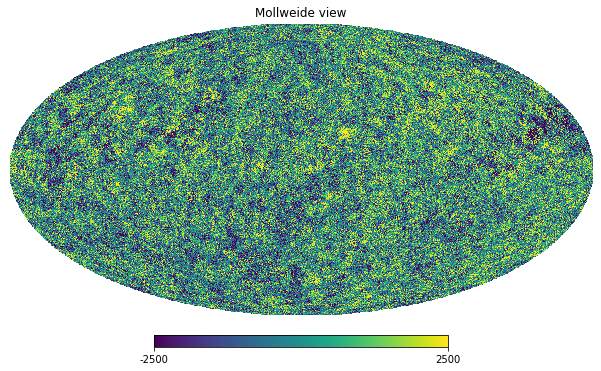

In [216]:
hp.mollview(removePeculiar,max=2500,min=-2500)

In [212]:
mixture = sklearn.mixture.GaussianMixture()

# result
r = mixture.fit((removePeculiar)[:, np.newaxis]) # GMM requires 2D data as of sklearn version 0.16
print("mean : %f, std dev : %f" % (r.means_[0, 0], np.sqrt(r.covariances_[0, 0])))

mean : -0.000011, std dev : 2034.052341


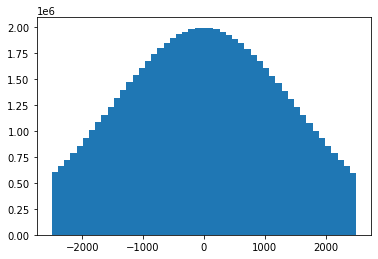

In [213]:
plt.hist(removePeculiar,bins=np.linspace(-2500,2500));

In [214]:
mixture = sklearn.mixture.GaussianMixture()

# result
r = mixture.fit((velField_LowL)[:, np.newaxis]) # GMM requires 2D data as of sklearn version 0.16
print("mean : %f, std dev : %f" % (r.means_[0, 0], np.sqrt(r.covariances_[0, 0])))

mean : -719.786417, std dev : 1955.227982


In [215]:
mixture = sklearn.mixture.GaussianMixture()

# result
r = mixture.fit((veff_recon_ClRescale)[:, np.newaxis]) # GMM requires 2D data as of sklearn version 0.16
print("mean : %f, std dev : %f" % (r.means_[0, 0], np.sqrt(r.covariances_[0, 0])))

mean : -719.786406, std dev : 1955.253105
